<a href="https://colab.research.google.com/github/mingmingbupt/tensorflow/blob/master/tf_keras_regression_wide_deep_multi_output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

1.15.0
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
matplotlib 3.2.0
numpy 1.18.2
pandas 0.25.3
sklearn 0.22.2.post1
tensorflow 1.15.0
tensorflow.python.keras.api._v1.keras 2.2.4-tf


In [6]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [7]:
from sklearn.model_selection import train_test_split

x_train_all, x_test, y_train_all, y_test = train_test_split(
    housing.data, housing.target, random_state = 7)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_all, y_train_all, random_state = 11)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)


(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

In [9]:
# 多输出输出并不是wide&deep模型所需要的，而是说我们现实问题中可能遇到的一种形式
# 我们来实现下如何在keras里实现多输出的网络结构，多输出的网络结构主要针对多任务学习的问题
# 比如说在房价问题里，除了预测当前房价，我们还要预测一年后的房价是多少，那我们就有两个预测任务
# 我们这个模型就要给出两个预测结果
# 多输出的实现方法如下
# 这里假设另一个问题呢 也是预测当前房价，这样这两个问题都是预测当前房价，我们把第二个任务放到hidden2上去实现。
# 也就是hidden2 经过全连接层再输出一个值
input_wide = keras.layers.Input(shape=[5])
input_deep = keras.layers.Input(shape=[6])
hidden1 = keras.layers.Dense(30, activation='relu')(input_deep)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
concat = keras.layers.concatenate([input_wide, hidden2])
output = keras.layers.Dense(1)(concat)
output2 = keras.layers.Dense(1)(hidden2)
model = keras.models.Model(inputs = [input_wide, input_deep],
                           outputs = [output, output2])
        

model.compile(loss="mean_squared_error", optimizer="sgd")
callbacks = [keras.callbacks.EarlyStopping(
    patience=5, min_delta=1e-2)]
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 30)           210         input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 30)           930         dense[0][0]                      
_____________

In [10]:
x_train_scaled_wide = x_train_scaled[:, :5]
x_train_scaled_deep = x_train_scaled[:, 2:]
x_valid_scaled_wide = x_valid_scaled[:, :5]
x_valid_scaled_deep = x_valid_scaled[:, 2:]
x_test_scaled_wide = x_test_scaled[:, :5]
x_test_scaled_deep = x_test_scaled[:, 2:]

history = model.fit([x_train_scaled_wide, x_train_scaled_deep],
                    [y_train, y_train],
                    validation_data = (
                        [x_valid_scaled_wide, x_valid_scaled_deep],
                        [y_valid, y_valid]),
                    epochs = 100,
                    callbacks = callbacks)

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 1s 72us/sample - loss: 2.0848 - dense_2_loss: 0.7276 - dense_3_loss: 1.3565 - val_loss: 1.3774 - val_dense_2_loss: 0.5253 - val_dense_3_loss: 0.8518
Epoch 2/100
11610/11610 [==============================] - 1s 46us/sample - loss: 1.5680 - dense_2_loss: 0.6689 - dense_3_loss: 0.8986 - val_loss: 1.1502 - val_dense_2_loss: 0.4968 - val_dense_3_loss: 0.6532
Epoch 3/100
11610/11610 [==============================] - 1s 48us/sample - loss: 0.9750 - dense_2_loss: 0.4400 - dense_3_loss: 0.5351 - val_loss: 0.9754 - val_dense_2_loss: 0.4336 - val_dense_3_loss: 0.5417
Epoch 4/100
11610/11610 [==============================] - 1s 48us/sample - loss: 0.8755 - dense_2_loss: 0.3963 - dense_3_loss: 0.4791 - val_loss: 0.8692 - val_dense_2_loss: 0.3958 - val_dense_3_loss: 0.4736
Epoch 5/100
11610/11610 [==============================] - 1s 49us/sample - loss: 0.8395 - dense_2_loss: 0.3831 - dense

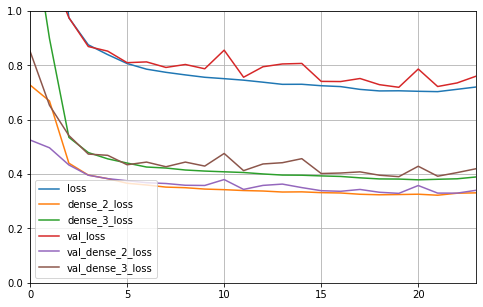

In [11]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()
plot_learning_curves(history)
#总的loss dense_2_loss dense_3_loss


In [12]:
model.evaluate([x_test_scaled_wide, x_test_scaled_deep],
               [y_test, y_test])

5160/5160 [==============================] - 0s 24us/sample - loss: 0.7377 - dense_2_loss: 0.3362 - dense_3_loss: 0.4017


[0.7376671864080798, 0.33618012, 0.401667]